In [2]:
import time, requests, re
from urllib.parse import urlparse
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from collections import defaultdict
from tweepy import OAuthHandler, API

from urllib.parse import parse_qs, quote, unquote, urlparse
import pandas as pd
import pprint
import json, os

from difflib import SequenceMatcher
import time, requests, re, random, tldextract

from googleapiclient.discovery import build

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
pp = pprint.PrettyPrinter(width=41, compact=True)

DIRECTORY_PATH = "D:/MSc Data Science/Elective Modules - Research Modules/[INF-DS-RMB] Research Module B/RM Code/Sentiment-Classification-Youtube-Comments-Political-Affiliation/"

In [4]:
# counting the number of videos scraped till now

In [29]:
def count_num_videos_and_channels(leaning, input_file):
    list_video_ids = []
    number_of_channels = 0
    with open(input_file, 'r') as fin:
        for line in fin:
            number_of_channels += 1
            channel_videos = json.loads(line.rstrip())
            for video in channel_videos['video_ids']:
                list_video_ids.append(video)
    print("Total {} Leaning YT Channels: {} | And total Videos:: {}".format(leaning, number_of_channels, len(list_video_ids)))

In [30]:
input_file = os.path.join(DIRECTORY_PATH, "data/6. video_ids.json")
count_num_videos_and_channels("Left", input_file)

input_file = os.path.join(DIRECTORY_PATH, "data/6. video_ids_centre_right.json")
count_num_videos_and_channels("Centre Right", input_file)

input_file = os.path.join(DIRECTORY_PATH, "data/6. video_ids_right.json")
count_num_videos_and_channels("Right", input_file)

Total Left Leaning YT Channels: 525 | And total Videos:: 165067
Total Centre Right Leaning YT Channels: 189 | And total Videos:: 59300
Total Right Leaning YT Channels: 109 | And total Videos:: 23502


In [9]:
# reading the comments form json and geenerating statistics

In [15]:
french_stop_words = ["a","à","â","abord","afin","cest", "ah","ai","aie","ainsi","allaient","allo","allô","allons","après","assez","attendu","au","aucun","aucune","aujourd","aujourd'hui","auquel","aura","auront","aussi","autre","autres","aux","auxquelles","auxquels","avaient","avais","avait","avant","avec","avoir","ayant","b","bah","beaucoup","bien","bigre","boum","bravo","brrr","c","ça","car","ce","ceci","cela","celle","celle-ci","celle-là","celles","celles-ci","celles-là","celui","celui-ci","celui-là","cent","cependant","certain","certaine","certaines","certains","certes","ces","cet","cette","ceux","ceux-ci","ceux-là","chacun","chaque","cher","chère","chères","chers","chez","chiche","chut","ci","cinq","cinquantaine","cinquante","cinquantième","cinquième","clac","clic","combien","comme","comment","compris","concernant","contre","couic","crac","d","da","dans","de","debout","dedans","dehors","delà","depuis","derrière","des","dès","désormais","desquelles","desquels","dessous","dessus","deux","deuxième","deuxièmement","devant","devers","devra","différent","différente","différentes","différents","dire","divers","diverse","diverses","dix","dix-huit","dixième","dix-neuf","dix-sept","doit","doivent","donc","dont","douze","douzième","dring","du","duquel","durant","e","effet","eh","elle","elle-même","elles","elles-mêmes","en","encore","entre","envers","environ","es","ès","est","et","etant","étaient","étais","était","étant","etc","été","etre","être","eu","euh","eux","eux-mêmes","excepté","f","façon","fais","faisaient","faisant","fait","feront","fi","flac","floc","font","g","gens","h","ha","hé","hein","hélas","hem","hep","hi","ho","holà","hop","hormis","hors","hou","houp","hue","hui","huit","huitième","hum","hurrah","i","il","ils","importe","j","je","jusqu","jusque","k","l","la","là","laquelle","las","le","lequel","les","lès","lesquelles","lesquels","leur","leurs","longtemps","lorsque","lui","lui-même","m","ma","maint","mais","malgré","me","même","mêmes","merci","mes","mien","mienne","miennes","miens","mille","mince","moi","moi-même","moins","mon","moyennant","n","na","ne","néanmoins","neuf","neuvième","ni","nombreuses","nombreux","non","nos","notre","nôtre","nôtres","nous","nous-mêmes","nul","o","o|","ô","oh","ohé","olé","ollé","on","ont","onze","onzième","ore","ou","où","ouf","ouias","oust","ouste","outre","p","paf","pan","par","parmi","partant","particulier","particulière","particulièrement","pas","passé","pendant","personne","peu","peut","peuvent","peux","pff","pfft","pfut","pif","plein","plouf","plus","plusieurs","plutôt","pouah","pour","pourquoi","premier","première","premièrement","près","proche","psitt","puisque","q","qu","quand","quant","quanta","quant-à-soi","quarante","quatorze","quatre","quatre-vingt","quatrième","quatrièmement","que","quel","quelconque","quelle","quelles","quelque","quelques","quelqu'un","quels","qui","quiconque","quinze","quoi","quoique","r","revoici","revoilà","rien","s","sa","sacrebleu","sans","sapristi","sauf","se","seize","selon","sept","septième","sera","seront","ses","si","sien","sienne","siennes","siens","sinon","six","sixième","soi","soi-même","soit","soixante","son","sont","sous","stop","suis","suivant","sur","surtout","t","ta","tac","tant","te","té","tel","telle","tellement","telles","tels","tenant","tes","tic","tien","tienne","tiennes","tiens","toc","toi","toi-même","ton","touchant","toujours","tous","tout","toute","toutes","treize","trente","très","trois","troisième","troisièmement","trop","tsoin","tsouin","tu","u","un","une","unes","uns","v","va","vais","vas","vé","vers","via","vif","vifs","vingt","vivat","vive","vives","vlan","voici","voilà","vont","vos","votre","vôtre","vôtres","vous","vous-mêmes","vu","w","x","y","z","zut","alors","aucuns","bon","devrait","dos","droite","début","essai","faites","fois","force","haut","ici","juste","maintenant","mine","mot","nommés","nouveaux","parce","parole","personnes","pièce","plupart","seulement","soyez","sujet","tandis","valeur","voie","voient","état","étions"]

In [16]:
german_stop_words = ["a","ab","aber","ach","acht","achte","achten","achter","achtes","ag","alle","allein","allem","allen","aller","allerdings","alles","allgemeinen","als","also","am","an","andere","anderen","andern","anders","au","auch","auf","aus","ausser","außer","ausserdem","außerdem","b","bald","bei","beide","beiden","beim","beispiel","bekannt","bereits","besonders","besser","besten","bin","bis","bisher","bist","c","d","da","dabei","dadurch","dafür","dagegen","daher","dahin","dahinter","damals","damit","danach","daneben","dank","dann","daran","darauf","daraus","darf","darfst","darin","darüber","darum","darunter","das","dasein","daselbst","dass","daß","dasselbe","davon","davor","dazu","dazwischen","dein","deine","deinem","deiner","dem","dementsprechend","demgegenüber","demgemäss","demgemäß","demselben","demzufolge","den","denen","denn","denselben","der","deren","derjenige","derjenigen","dermassen","dermaßen","derselbe","derselben","des","deshalb","desselben","dessen","deswegen","d.h","dich","die","diejenige","diejenigen","dies","diese","dieselbe","dieselben","diesem","diesen","dieser","dieses","dir","doch","dort","drei","drin","dritte","dritten","dritter","drittes","du","durch","durchaus","dürfen","dürft","durfte","durften","e","eben","ebenso","ehrlich","ei","ei,","eigen","eigene","eigenen","eigener","eigenes","ein","einander","eine","einem","einen","einer","eines","einige","einigen","einiger","einiges","einmal","eins","elf","en","ende","endlich","entweder","er","Ernst","erst","erste","ersten","erster","erstes","es","etwa","etwas","euch","f","früher","fünf","fünfte","fünften","fünfter","fünftes","für","g","gab","ganz","ganze","ganzen","ganzer","ganzes","gar","gedurft","gegen","gegenüber","gehabt","gehen","geht","gekannt","gekonnt","gemacht","gemocht","gemusst","genug","gerade","gern","gesagt","geschweige","gewesen","gewollt","geworden","gibt","ging","gleich","gott","gross","groß","grosse","große","grossen","großen","grosser","großer","grosses","großes","gut","gute","guter","gutes","h","habe","haben","habt","hast","hat","hatte","hätte","hatten","hätten","heisst","her","heute","hier","hin","hinter","hoch","i","ich","ihm","ihn","ihnen","ihr","ihre","ihrem","ihren","ihrer","ihres","im","immer","in","indem","infolgedessen","ins","irgend","ist","j","ja","jahr","jahre","jahren","je","jede","jedem","jeden","jeder","jedermann","jedermanns","jedoch","jemand","jemandem","jemanden","jene","jenem","jenen","jener","jenes","jetzt","k","kam","kann","kannst","kaum","kein","keine","keinem","keinen","keiner","kleine","kleinen","kleiner","kleines","kommen","kommt","können","könnt","konnte","könnte","konnten","kurz","l","lang","lange","leicht","leide","lieber","los","m","machen","macht","machte","mag","magst","mahn","man","manche","manchem","manchen","mancher","manches","mann","mehr","mein","meine","meinem","meinen","meiner","meines","mensch","menschen","mich","mir","mit","mittel","mochte","möchte","mochten","mögen","möglich","mögt","morgen","muss","muß","müssen","musst","müsst","musste","mussten","n","na","nach","nachdem","nahm","natürlich","neben","nein","neue","neuen","neun","neunte","neunten","neunter","neuntes","nicht","nichts","nie","niemand","niemandem","niemanden","noch","nun","nur","o","ob","oben","oder","offen","oft","ohne","Ordnung","p","q","r","recht","rechte","rechten","rechter","rechtes","richtig","rund","s","sa","sache","sagt","sagte","sah","satt","schlecht","Schluss","schon","sechs","sechste","sechsten","sechster","sechstes","sehr","sei","seid","seien","sein","seine","seinem","seinen","seiner","seines","seit","seitdem","selbst","sich","sie","sieben","siebente","siebenten","siebenter","siebentes","sind","so","solang","solche","solchem","solchen","solcher","solches","soll","sollen","sollte","sollten","sondern","sonst","sowie","später","statt","t","tag","tage","tagen","tat","teil","tel","tritt","trotzdem","tun","u","über","überhaupt","übrigens","uhr","um","und","und?","uns","unser","unsere","unserer","unter","v","vergangenen","viel","viele","vielem","vielen","vielleicht","vier","vierte","vierten","vierter","viertes","vom","von","vor","w","wahr?","während","währenddem","währenddessen","wann","war","wäre","waren","wart","warum","was","wegen","weil","weit","weiter","weitere","weiteren","weiteres","welche","welchem","welchen","welcher","welches","wem","wen","wenig","wenige","weniger","weniges","wenigstens","wenn","wer","werde","werden","werdet","wessen","wie","wieder","will","willst","wir","wird","wirklich","wirst","wo","wohl","wollen","wollt","wollte","wollten","worden","wurde","würde","wurden","würden","x","y","z","z.b","zehn","zehnte","zehnten","zehnter","zehntes","zeit","zu","zuerst","zugleich","zum","zunächst","zur","zurück","zusammen","zwanzig","zwar","zwei","zweite","zweiten","zweiter","zweites","zwischen","zwölf","euer","eure","hattest","hattet","jedes","mußt","müßt","sollst","sollt","soweit","weshalb","wieso","woher","wohin"]

In [17]:
number_dictionary = {"1" : "one", "2" : "two", "3": "three", "4" : "four", "5": "five", "6": "six", "7" : "seven", "8": "eight", "9":"nine", "0":"zero"}
dictionary  = {"'cause": 'because',
 "'s": 'is',
 "'tis": 'it is',
 "'twas": 'it was',
 "Ha'ta": 'even',
 "I'd": 'I had',
 "I'll": 'I shall',
 "I'm": 'I am',
 "I'm'a": 'I am about to',
 "I'm'o": 'I am going to',
 "I've": 'I have',
 "S'e": 'oh yeah',
 "ain't": 'am not',
 "aren't": 'are not',
 "cain't": 'cannot',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "daren't": 'dare not',
 "daresn't": 'dare not',
 "dasn't": 'dare not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "e'er": 'ever',
 "everyone's": 'everyone is',
 'finna': 'fixing to',
 'gimme': 'give me',
 "giv'n": 'given',
 "gon't": 'go not',
 'gonna': 'going to',
 'gotta': 'got to',
 "hadn't": 'had not',
 "hasn't": 'is not',
 "haven't": 'have not',
 "he'd": 'he had',
 "he'll": 'he shall',
 "he's": 'he is',
 "he've": 'he have',
 "how'd": 'how did',
 "how'll": 'how will',
 "how're": 'how are',
 "how's": 'how is',
 'howdy': 'how do you do',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'll": 'it shall',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "may've": 'may have',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "ne'er": 'never',
 "needn't": 'need not',
 "o'clock": 'of the clock',
 "o'er": 'over',
 "ol'": 'old',
 "oughtn't": 'ought not',
 'rarely': 'cannot',
 "shalln't": 'shall not',
 "shan't": 'shall not',
 "she'd": 'she had',
 "she'll": 'she shall',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so're": 'so are',
 "somebody's": 'somebody is',
 "someone's": 'someone is',
 "something's": 'something is',
 "that'd": 'that would',
 "that'll": 'that shall',
 "that're": 'that are',
 "that's": 'that is',
 "there'd": 'there had',
 "there'll": 'there shall',
 "there're": 'there are',
 "there's": 'there is',
 "these're": 'these are',
 "they'd": 'they had',
 "they'll": 'they shall',
 "they're": 'they are',
 "they've": 'they have',
 "this's": 'this is',
 "those're": 'those are',
 "to've": 'to have',
 "wasn't": 'was not',
 "we'd": 'we had',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "what'd": 'what did',
 "what'll": 'what shall',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "where'd": 'where did',
 "where're": 'where are',
 "where's": 'where is',
 "where've": 'where have',
 "which's": 'which is',
 "who'd": 'who would',
 "who'd've": 'who would have',
 "who'll": 'who shall',
 "who're": 'who are',
 "who's": 'who is',
 "who've": 'who have',
 "whom'st": 'whom hast',
 "whom'st'd've": 'whom hast had have',
 "why'd": 'why did',
 "why're": 'why are',
 "why's": 'why is',
 "won't": 'will not',
 "would've": 'would have',
 "wouldn't": 'would not',
 "y'all": 'you all',
 "y'all'd've": 'you all would have',
 "you'd": 'you had',
 "you'll": 'you shall',
 "you're": 'you are',
 "you've": 'you have'}

In [4]:
import os

def create_df(input_file):

    list_title = []
    list_category = []
    list_transcript = []
    list_of_comments_comment = []

    num_channels = 0
    with open(input_file, 'r') as fin:
        for line in fin:
            channel_videos = json.loads(line.rstrip())

            num_channels += 1

            for video in channel_videos['video_ids']:

                list_comment = []
                list_title.append(video['title'])
                list_category.append(video['category'])
                list_transcript.append(video['transcript'])

                if isinstance(video['top_comment_list'], list):
                    if len(video['top_comment_list']) > 0:
                        for comments in video['top_comment_list']:
                            list_comment.append(comments['comment'])

                # if there are no comments in the entire channel
                if len(list_comment) > 0:
                    list_of_comments_comment.append(list_comment)
                else:
                    list_of_comments_comment.append(["NA"])
                    
                    
    vid_comment_df = pd.DataFrame(
        {'Video Title': list_title,
         'Category': list_category,
         'Transcript': list_transcript,
         'Comments': list_of_comments_comment
        })
    
    print("List of titles: {} | Categories: {} | Transcript List: {} | comments list len: {}".format(len(list_title), len(list_category), len(list_transcript), len(list_of_comments_comment)))
    print("Number of channels: {}".format(num_channels))
    
    return vid_comment_df

def count_comments(comments_df):
    # to count the number of comments
    len_comments = 0
    for s in comments_df["Comments"]:

        if "NA" not in s:
            len_comments += len(s)

    print("Total number of comments YT channel: {}".format(len_comments))

def calculate_hashtags(comment_df):
    text = " ".join([" ".join(s)  if isinstance(s,list) else s for s in comment_df["Comments"]])
    text = text.replace("NA","")
    
    hastags = set([i[1:] for i in text.split() if i.startswith("#")])

    hastags = [str(s) for s in hastags]
    
    print("Number of unique hashtags: {}".format(len(hastags)))

    return text, hastags

# Review the questions:
def mappingWords(questions,dictionary):
    return " ".join([dictionary.get(w,w) for w in questions.split()])

def comment_cloud(leaning, text, dictionary):

    text = mappingWords(text, dictionary)
    text = text.lower()
    text = mappingWords(text, dictionary)
    text = re.sub(r"[^A-Za-z0-9 ]", "", text)

    # Create and generate a word cloud image:
    stopwords = set(STOPWORDS)
    stopwords.update(french_stop_words)
    stopwords.update(german_stop_words)

    wordcloud = WordCloud(width = 1200, height = 700,
                          stopwords=stopwords, max_font_size=50, max_words=1000, background_color="black").generate(text.lower())

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    # Save the image in the img folder:
    wordcloud.to_file("Cloud Comments on {} channel.png".format(leaning))

def hashtag_cloud(leaning, hastags):
    hastags = " ".join(hastags)
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1200, height = 700,
                          max_font_size=50, max_words=1000, background_color="black").generate(hastags)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    wordcloud.to_file("Cloud Hashtags on {} channel.png".format(leaning))


In [5]:
print("For Left Leaning channels")
leaning = "Left"
input_file = os.path.join(DIRECTORY_PATH, "data/7. comments.json")
vid_comment_df = create_df(input_file)
count_comments(vid_comment_df)
texts, hastags = calculate_hashtags(vid_comment_df)
# cloud for comments
comment_cloud(leaning, texts, dictionary)
# cloud for hashtags
hashtag_cloud(leaning, hastags)
print("*****************************************************************************************")

"""print("For Right Leaning channels")
leaning = "Right"
input_file = os.path.join(DIRECTORY_PATH, "data/7. comments RIGHT.json")
vid_comment_df = create_df(input_file)
count_comments(vid_comment_df)
texts, hastags = calculate_hashtags(vid_comment_df)
# cloud for comments
comment_cloud(leaning, texts, dictionary)
# cloud for hashtags
hashtag_cloud(leaning, hastags)
print("*****************************************************************************************")"""

# this contains combined data for center right and right
print("For Center Right Leaning channels")
leaning = "Center Right"
input_file = os.path.join(DIRECTORY_PATH, "data/7. comments CENTRE RIGHT.json")
vid_comment_df = create_df(input_file)
count_comments(vid_comment_df)
texts, hastags = calculate_hashtags(vid_comment_df)
# cloud for comments
comment_cloud(leaning, texts, dictionary)
# cloud for hashtags
hashtag_cloud(leaning, hastags)
print("*****************************************************************************************")

For Left Leaning channels
*****************************************************************************************
For Right Leaning channels
*****************************************************************************************
For Center Right Leaning channels
List of titles: 59300 | Categories: 59300 | Transcript List: 59300 | comments list len: 59300
Number of channels: 189
Total number of comments YT channel: 1589436
Number of unique hashtags: 698
*****************************************************************************************


In [ ]:
"""For Left Leaning channels
List of titles: 34739 | Categories: 34739 | Transcript List: 34739 | comments list len: 34739
Number of channels: 188
Total number of comments YT channel: 4850479
Number of unique hashtags: 6046
    
*****************************************************************************************
For Center Right Leaning channels
List of titles: 62456 | Categories: 62456 | Transcript List: 62456 | comments list len: 62456
Number of channels: 236
Total number of comments YT channel: 1694404
Number of unique hashtags: 805"""

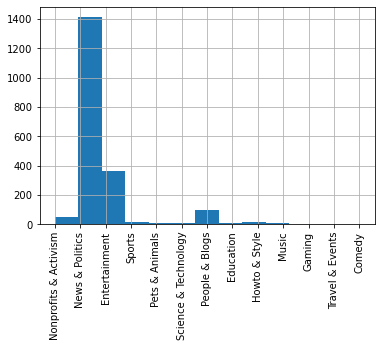

In [297]:
ax = comments_left["Category"].hist(bins=13)

fig = ax.get_figure()
plt.xticks(rotation=90)

fig.savefig('Category Left.jpg')
plt.show()

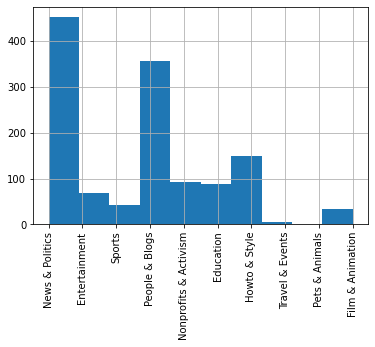

In [294]:
ax = comments_right["Category"].hist(bins=10)

fig = ax.get_figure()
plt.xticks(rotation=90)

fig.savefig('Category Right.jpg')
plt.show()